## Metric Learning with the Shogun Machine Learning Toolbox

#### Building up the intuition to understand LMNN

First of all, let us introduce LMNN through a simple example. For this purpose, we will be using the following two-dimensional toy data set:

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
x = numpy.array([[0,0],[-1,0.1],[0.3,-0.05],[0.7,0.3],[-0.2,-0.6],[-0.15,-0.63],[-0.25,0.55],[-0.28,0.67]])
y = numpy.array([0,0,0,0,1,1,2,2])

That is, there are eight feature vectors where each of them belongs to one out of three different classes (identified by either 0, 1, or 2). Let us have a look at this data:

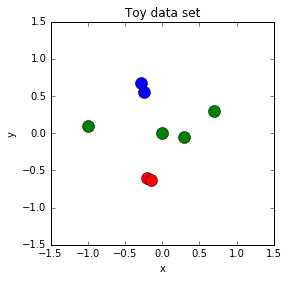

In [4]:
def plot_data(features,labels,axis,alpha=1.0):
    # separate features according to their class
    X0,X1,X2 = features[labels==0], features[labels==1], features[labels==2]
    
    # class 0 data
    axis.plot(X0[:,0], X0[:,1], 'o', color='green', markersize=12, alpha=alpha)
    # class 1 data
    axis.plot(X1[:,0], X1[:,1], 'o', color='red', markersize=12, alpha=alpha)
    # class 2 data
    axis.plot(X2[:,0], X2[:,1], 'o', color='blue', markersize=12, alpha=alpha)
    
    # set axes limits
    axis.set_xlim(-1.5,1.5)
    axis.set_ylim(-1.5,1.5)
    axis.set_aspect('equal')
    
    axis.set_xlabel('x')
    axis.set_ylabel('y')

figure,axis = pyplot.subplots(1,1)
plot_data(x,y,axis)
axis.set_title('Toy data set')
pyplot.show()

In the figure above, we can see that two of the classes are represented by two points that are, for each of these classes, very close to each other. The third class, however, has four points that are close to each other with respect to the y-axis, but spread along the x-axis.


If we were to apply kNN (k-nearest neighbors) in a data set like this, we would expect quite some errors using the standard Euclidean distance. This is due to the fact that the spread of the data is not similar amongst the feature dimensions. The following piece of code plots an ellipse on top of the data set. The ellipse in this case is in fact a circunference that helps to visualize how the Euclidean distance weights equally both feature dimensions.

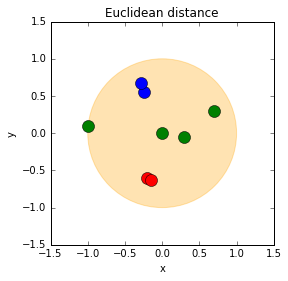

In [6]:
def make_covariance_ellipse(covariance):
    import matplotlib.patches as patches
    import scipy.linalg       as linalg
    
    # the ellipse is centered at (0,0)
    mean = numpy.array([0,0])
    
    # eigenvalue decomposition of the covariance matrix (w are eigenvalues and v eigenvectors),
    # keeping only the real part
    w,v = linalg.eigh(covariance)
    # normalize the eigenvector corresponding to the largest eigenvalue
    u = v[0]/linalg.norm(v[0])
    # angle in degrees
    angle = 180.0/numpy.pi*numpy.arctan(u[1]/u[0])
    # fill Gaussian ellipse at 2 standard deviation
    ellipse = patches.Ellipse(mean, 2*w[0]**0.5, 2*w[1]**0.5, 180+angle, color='orange', alpha=0.3)
    
    return ellipse

# represent the Euclidean distance
figure,axis = pyplot.subplots(1,1)
plot_data(x,y,axis)
ellipse = make_covariance_ellipse(numpy.eye(2))
axis.add_artist(ellipse)
axis.set_title('Euclidean distance')
pyplot.show()

A possible workaround to improve the performance of kNN in a data set like this would be to input to the kNN routine a distance measure. For instance, in the example above a good distance measure would give more weight to the y-direction than to the x-direction to account for the large spread along the x-axis. Nonetheless, it would be nicer (and, in fact, much more useful in practice) if this distance could be learnt automatically from the data at hand. Actually, LMNN is based upon this principle: given a number of neighbours k, find the Mahalanobis distance measure which maximizes kNN accuracy (using the given value for k) in a training data set. As we usually do in machine learning, under the assumption that the training data is an accurate enough representation of the underlying process, the distance learnt will not only perform well in the training data, but also have good generalization properties.

Now, let us use the [LMNN class](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CLMNN.html) implemented in Shogun to find the distance and plot its associated ellipse. If everything goes well, we will see that the new ellipse only overlaps with the data points of the green class.

First, we need to wrap the data into Shogun's feature and label objects:

In [47]:
x.T.shape

(2, 8)

In [16]:
from modshogun import RealFeatures, MulticlassLabels

features = RealFeatures(x.T)
labels   = MulticlassLabels(y.astype(numpy.float64))

Secondly, perform LMNN training:

In [39]:
from modshogun import LMNN

# number of target neighbours per example
k = 1

lmnn = LMNN(features,labels,k)
# set an initial transform as a start point of the optimization
init_transform = numpy.eye(2)
lmnn.set_maxiter(5000)
lmnn.train(init_transform)

LMNN is an iterative algorithm. The argument given to train represents the initial state of the solution. By default, if no argument is given, then LMNN uses PCA to obtain this initial value.

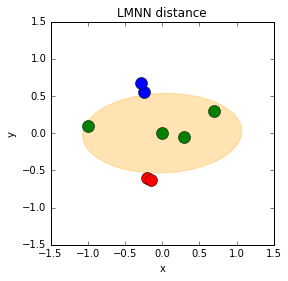

In [40]:
# get the linear transform from LMNN
L = lmnn.get_linear_transform()
# square the linear transform to obtain the Mahalanobis distance matrix
M = numpy.matrix(numpy.dot(L.T,L))

# represent the distance given by LMNN
figure,axis = pyplot.subplots(1,1)
plot_data(x,y,axis)
ellipse = make_covariance_ellipse(M.I)
axis.add_artist(ellipse)
axis.set_title('LMNN distance')
pyplot.show()

## Beyond the main idea

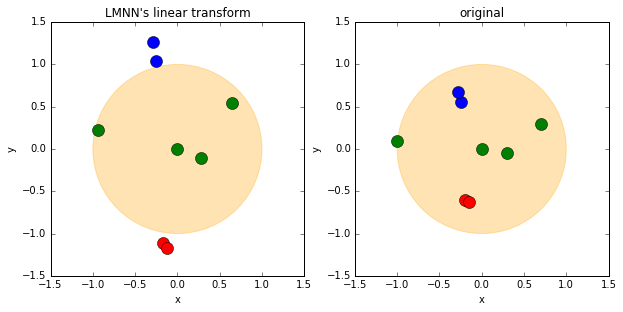

In [44]:
# project original data using L
lx = numpy.dot(L,x.T)

# represent the data in the projected space
figure,axis = pyplot.subplots(1,2, figsize=(10,5))
plot_data(lx.T,y,axis[0])
ellipse0 = make_covariance_ellipse(numpy.eye(2))
axis[0].add_artist(ellipse0)
axis[0].set_title('LMNN\'s linear transform')

ellipse1 = make_covariance_ellipse(numpy.eye(2))
plot_data(x,y,axis[1],1)
axis[1].add_artist(ellipse1)
axis[1].set_title('original')

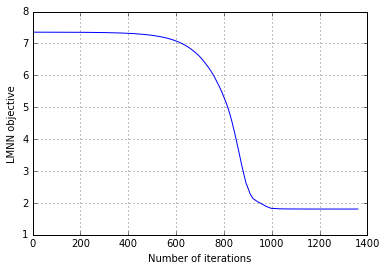

In [45]:
statistics = lmnn.get_statistics()
pyplot.plot(statistics.obj.get())
pyplot.grid(True)
pyplot.xlabel('Number of iterations')
pyplot.ylabel('LMNN objective')